In [1]:
import spacy
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.phrases import Phrases, Phraser
from spacy.pipeline import Pipe

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
nlp = spacy.load('en')

In [5]:
%matplotlib inline

# Read review json file to dataframe & simple EDA

In [6]:
review_df = pd.read_json('https://raw.githubusercontent.com/skinssong/BIA_660D/master/records.json', orient='records', lines=True)
review_df.head()

,date,hp_vote,id,star,text,with_pic,with_video
0,2017-03-04,214,R3FS49IG7WSV3T,5,These Rockbirds LED Flashlights I bought came ...,1,1
1,2018-02-10,14,RWJ5AI1HQ4RK9,4,"Given my many prior, poor experiences with sev...",0,0
2,2017-03-07,5,R3CLNL68XM159U,5,These are good quality tactical flashlights. T...,0,1
3,2017-09-13,3,RUVWAHWUBGYD9,4,"These ended up being very handy, but I didn't ...",1,0
4,2017-03-16,4,R35XJANJ4JHOTO,5,These are small enough to carry in a purse or ...,1,0


In [7]:
review_df.corr()

,hp_vote,star,with_pic,with_video
hp_vote,1.000000,-0.002805,0.280824,0.717234
star,-0.002805,1.000000,0.046621,0.044293
with_pic,0.280824,0.046621,1.000000,0.179337
with_video,0.717234,0.044293,0.179337,1.000000


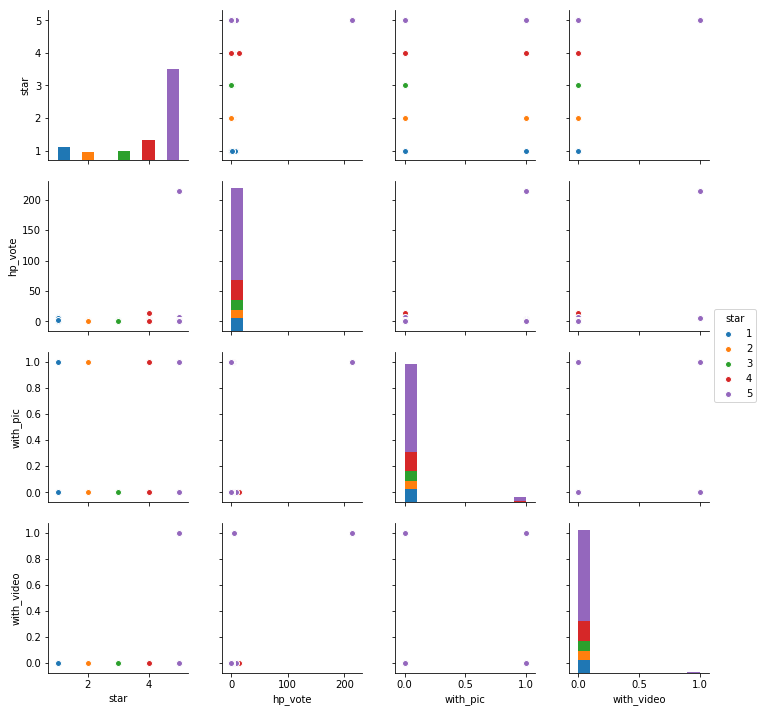

In [8]:
sns.pairplot(data=review_df[['star', 'hp_vote', 'with_pic', 'with_video']], hue='star')

/home/saul/miniconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


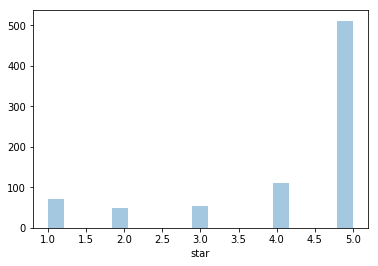

In [9]:
# Plot shows that there is a serious imbalance problem
sns.distplot(review_df['star'],kde=False)

In [10]:
review_df['text'][0]

'These Rockbirds LED Flashlights I bought came it a pack of 2 for only $9.99 which is a crazy good deal.  I collect LED flashlights and have about 30 right now but I really like these smaller ones because I can just keep them in my pocket.These are heavy duty and made with aluminum.  The battery compartment has an O ring to keep moisture out.  They are waterproof but not to be submerged in water but they will withstand rain.The beam is adjustable and you can see that in the video I provided to go with this review and I also show all 3 modes of lighting.  All you need to do is slightly tap the on and off switch and it will change modes.Please watch the video to get a better idea of what I am talking about.  Overall it is excellent for the price and you get 2!  I give this 5 stars easily.  I hoped this helped in some way.'

In [14]:
review_df['text_length'] = review_df['text'].str.len()
review_df['text_length'] = review_df['text_length'].apply(lambda x: np.log(x))

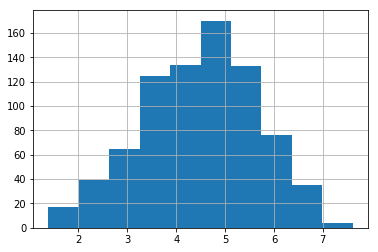

In [16]:
review_df['text_length'].hist()

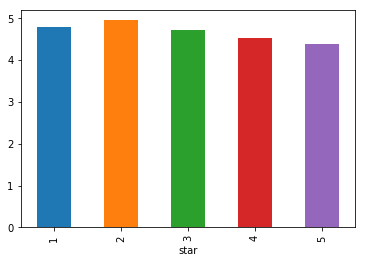

In [15]:
review_df.groupby('star').mean()['text_length'].plot(kind='bar')

# Conclusion Star does not affected much by review length or other collected attributes (by corr matrix)

# Build pipeline to transform text review

In [17]:
class KeepAscii(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_docs = []
        for doc in X:
            text = "".join(i for i in doc if ord(i) < 128 and not i.isdigit())
            new_docs.append(text)
        return new_docs

In [18]:
class PartOfSpeechFilter(BaseEstimator, TransformerMixin):
    def __init__(self, pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'), stop_words=None):
        self.pos_to_keep = pos_to_keep
        self.stop_words = stop_words
        
    def fit(self, text, y=None):
        return self
        
    def transform(self, text):
        preprocessed_sentences = []
        
        for doc in nlp.pipe(text, n_threads=8):
            if self.stop_words is not None:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep and t.lemma_ not in self.stop_words])
            else:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep])
            preprocessed_sentences.append(keep_tokens_string)
    
        return preprocessed_sentences 

In [19]:
from sklearn.feature_extraction import stop_words

In [20]:
class Colloc(BaseEstimator, TransformerMixin):
    def __init__(self, common_terms = list(stop_words.ENGLISH_STOP_WORDS) + ["'m", "'re", "'ll", "'s", "'ve", "'d", 'ca', 'is', 'of']):
        self.common_terms = common_terms
        
    def fit(self, X, y=None):
        token_text = []
        for doc in nlp.pipe(X, n_threads = 8):
            for sent in doc.sents:
                token_text.append([t.lemma_ for t in sent if not t.is_punct])
        
        bi_phrases = Phrases(token_text, common_terms=self.common_terms)
        self.colloc = Phraser(bi_phrases)
        return self
    
    def transform(self, X):
        colloc_reviews = []
        for doc in nlp.pipe(X):
            colloc_text = ' '.join(self.colloc[[t.lemma_ for t in doc]])
            colloc_reviews.append(colloc_text)
        return colloc_reviews

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
review_df['star'] = review_df['star'].apply(lambda x: 1*(x>3))

In [24]:
X = review_df['text']
y = review_df['star']

In [25]:
pipeline = Pipeline([('ascii', KeepAscii()),
                     ('bico', Colloc()),
                     ('trico', Colloc()),
                     ('posf', PartOfSpeechFilter()),
                     ('feats', FeatureUnion([('word_vec',TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=1500)),
                                             ('char_vec',TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=10000))]))
                    ])

In [26]:
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
X_train_transformed = pipeline.fit_transform(x_train)

In [28]:
X_train_transformed.shape

(638, 11335)

# Train and test with raw TF-IDF vector

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lg = LogisticRegression(C=4, dual=True)
lg2 = LogisticRegression(C=4, dual=True)

In [185]:
lg.fit(X_train_transformed, y_train)
y_pred = lg.predict(X_train_transformed)

In [186]:
conf_matrix1 = confusion_matrix(y_train, y_pred)
conf_matrix1

array([[138,   4],
       [  1, 495]])

Resample Train data and do test

In [187]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=2)
X_res, y_res = ada.fit_sample(X_train_transformed, y_train)

In [188]:
lg2.fit(X_res, y_res)
y_pred = lg2.predict(X_res)
conf_matrix = confusion_matrix(y_res, y_pred)
conf_matrix

array([[501,   2],
       [  4, 492]])

In [189]:
X_test_transformed = pipeline.transform(X_test)
y_test_pred1 = lg.predict(X_test_transformed)
y_test_pred2 = lg2.predict(X_test_transformed)

In [190]:
conf_matrix_t1 = confusion_matrix(y_test_pred1, y_test)
conf_matrix_t1

array([[ 15,   5],
       [ 19, 121]])

In [191]:
conf_matrix1_t2 = confusion_matrix(y_test_pred2, y_test)
conf_matrix1_t2

array([[ 19,  12],
       [ 15, 114]])

# Conclusion: Resample actually deteriates test performance

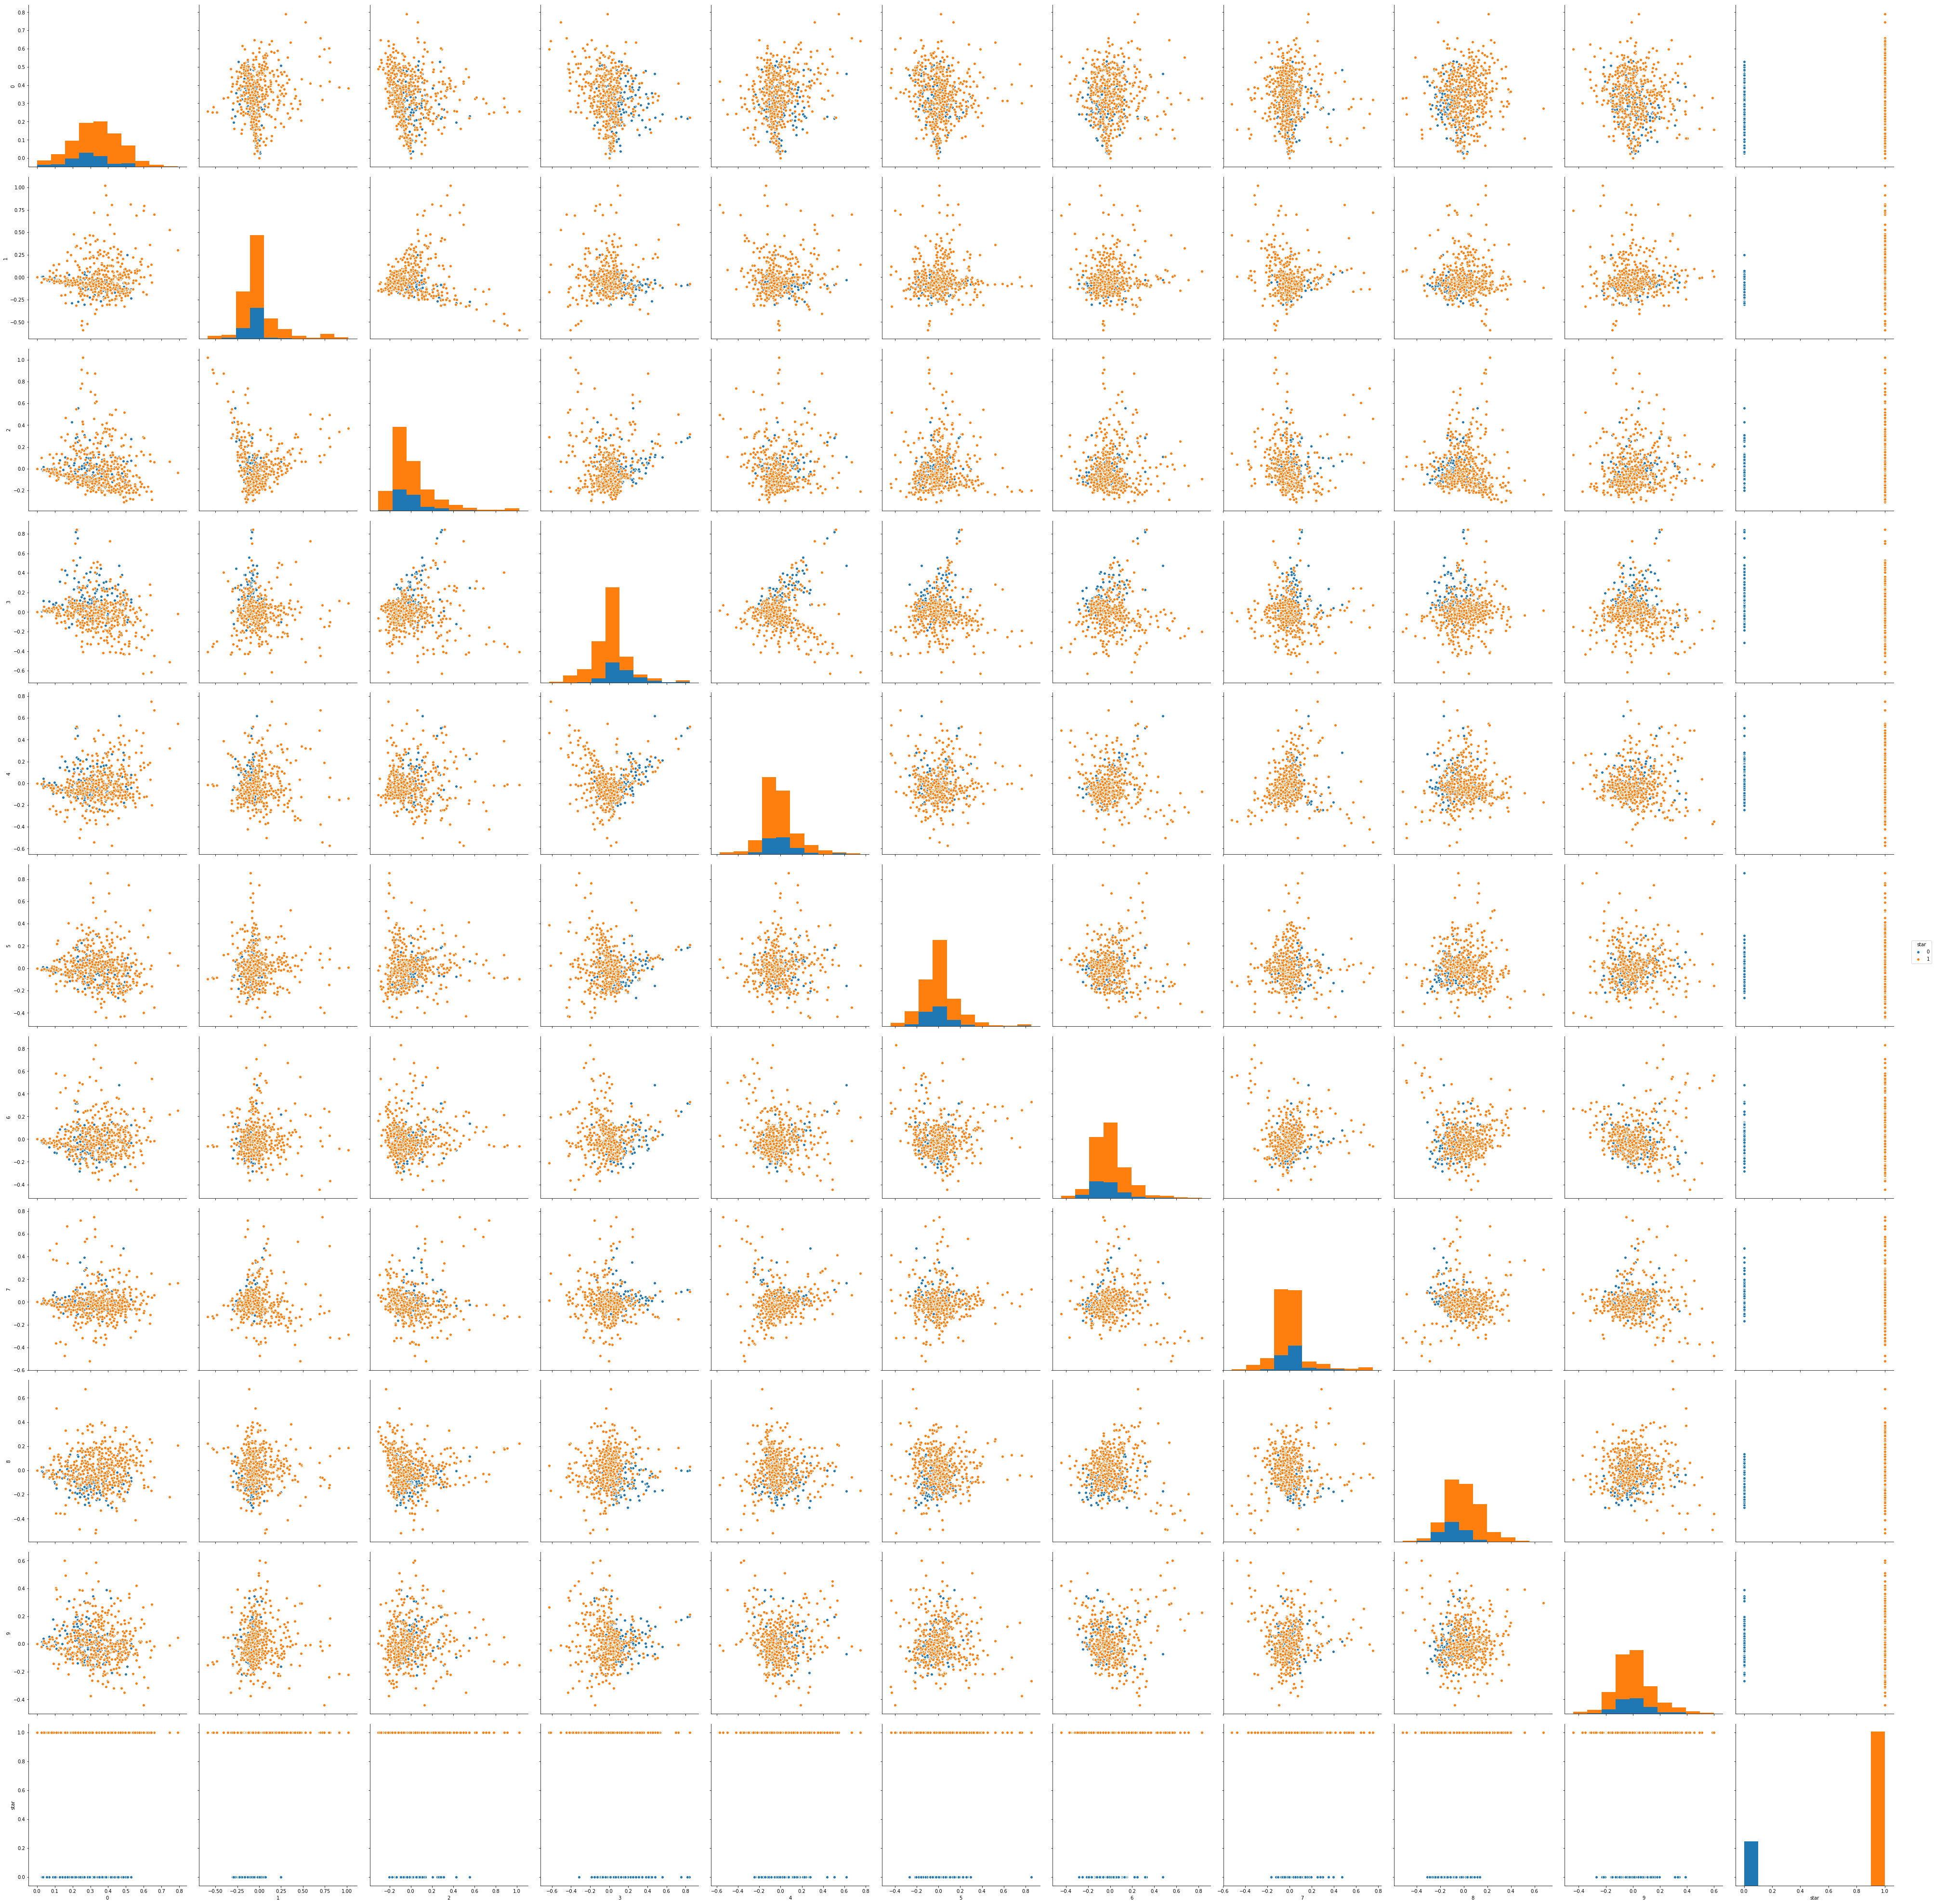

In [172]:
svd = TruncatedSVD(n_components=10, n_iter=20)
X_vis = svd.fit_transform(X_train_transformed)
X_vis = DataFrame(X_vis, index= y_train.index)
X_vis['star'] = y_train
sns.pairplot(data=X_vis, hue='star',size=5)

In [173]:
sum(svd.explained_variance_ratio_) #with only ten dimension

0.15453745824924017

In [174]:
svd = TruncatedSVD(n_components=20, n_iter=50)
X_vis = svd.fit_transform(X_train_transformed)
X_vis = DataFrame(X_vis, index= y_train.index)

In [175]:
sum(svd.explained_variance_ratio_) #with twenty dimension, higher worsened model performance

0.24174353115380998

In [176]:
X_vis.shape, y_train.shape

((638, 20), (638,))

In [177]:
# Usually performs extremely well
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, criterion='entropy', oob_score=True,class_weight={0:0.7, 1:1},n_jobs=4)

In [178]:
#lg.fit(X_res, y_res)
rf.fit(X_vis, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.7, 1: 1},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=4, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [179]:
rf.oob_score_

0.8463949843260188

In [180]:
X_test_vis = svd.transform(X_test_transformed)

In [182]:
y_test_pred = rf.predict(X_test_vis)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
conf_matrix_test

array([[ 14,  20],
       [ 12, 114]])

In [170]:
X_train_transformed.shape, X_test_transformed.shape

((638, 11335), (160, 11335))

In [161]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C':[0.1, 1, 10, 100]}]
clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, cv=5, n_jobs=8)
clf.fit(X_train_transformed, y_train)
clf.best_params_

{'C': 10}

In [162]:
tuned_parameters = [{'C':list(range(5,20))}]
clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, cv=5, n_jobs=8)
clf.fit(X_train_transformed, y_train)                           
clf.best_params_

{'C': 8}

## grid search to find best penalty parameter for logistic regression

In [163]:
y_grid_pred = clf.best_estimator_.predict(X_test_transformed)

In [164]:
conf_grid_test = confusion_matrix(y_test, y_grid_pred)
conf_grid_test

array([[ 15,  19],
       [  5, 121]])

In [183]:
conf_matrix_t1

array([[ 15,   5],
       [ 19, 121]])

# log regression without resample, and parameter tuning does not make the model perform better